# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

In [2]:
from statsmodels.regression.linear_model import yule_walker

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
import numpy as np
import pandas as pd

In [5]:
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [6]:
import random

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing")

In [38]:
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Download the dataset and check the data structure

In [8]:
data = loadmat("S1_E1_A1.mat")
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


Now, load in the EMG data. Check the data structure printing data dimension and type.

In [9]:
emg_data = data["emg"]
print("EMG data dimension: {}".format(emg_data.shape))
print("EMG data type: {}".format(type(emg_data)))

EMG data dimension: (2292526, 16)
EMG data type: <class 'numpy.ndarray'>


Load in hand kinematics labels. Select only the joint angles associated to the joint angles of interest (3,6,8,11,14 see the glove image here https://ninapro.hevs.ch/instructions/DB8.html). Take only the part of data labels where index finger is involved in movement (see cell above). Check the data structure printing data dimension and type.

In [10]:
# Only regressing on finger joint 3,6,8,11,14
glove_data_index = data["glove"][:, [2,5,7,10,13]]
print("Glove data dimension: {}".format(glove_data_index.shape))
print("Glove data type: {}".format(type(glove_data_index)))

Glove data dimension: (2292526, 5)
Glove data type: <class 'numpy.ndarray'>


In [11]:
data['restimulus'].shape

(2292526, 1)

In [12]:
stimulus = data['restimulus']
repetition = data['rerepetition']
# For each different stimulus, take the datapoints where that stimulus is active
for stimulus_value in np.unique(stimulus):
    unique_stimulus = stimulus_value
    indices = np.where(stimulus == unique_stimulus)[0]
    # Separate the indices into contiguous segments
    s = np.split(indices, np.where(np.diff(indices) != 1)[0]+1)
    # For each contiguous segment, print the start and end indices
    for segment in s:
        start_idx = segment[0]
        end_idx = segment[-1]
        print(f"Stimulus {unique_stimulus}: Start index: {start_idx}, End index: {end_idx}")

Stimulus 0: Start index: 0, End index: 19893
Stimulus 0: Start index: 28440, End index: 41556
Stimulus 0: Start index: 50018, End index: 63754
Stimulus 0: Start index: 74352, End index: 85626
Stimulus 0: Start index: 93778, End index: 107525
Stimulus 0: Start index: 116170, End index: 129578
Stimulus 0: Start index: 137831, End index: 152056
Stimulus 0: Start index: 160578, End index: 173689
Stimulus 0: Start index: 181988, End index: 196512
Stimulus 0: Start index: 203940, End index: 219337
Stimulus 0: Start index: 225005, End index: 246792
Stimulus 0: Start index: 255908, End index: 268707
Stimulus 0: Start index: 278123, End index: 291175
Stimulus 0: Start index: 299213, End index: 314114
Stimulus 0: Start index: 322563, End index: 336733
Stimulus 0: Start index: 345594, End index: 358217
Stimulus 0: Start index: 369162, End index: 380878
Stimulus 0: Start index: 389867, End index: 402923
Stimulus 0: Start index: 416007, End index: 424823
Stimulus 0: Start index: 433192, End index: 

# Input data visualisation and preprocessing

Number of channels in the EMG data: 16


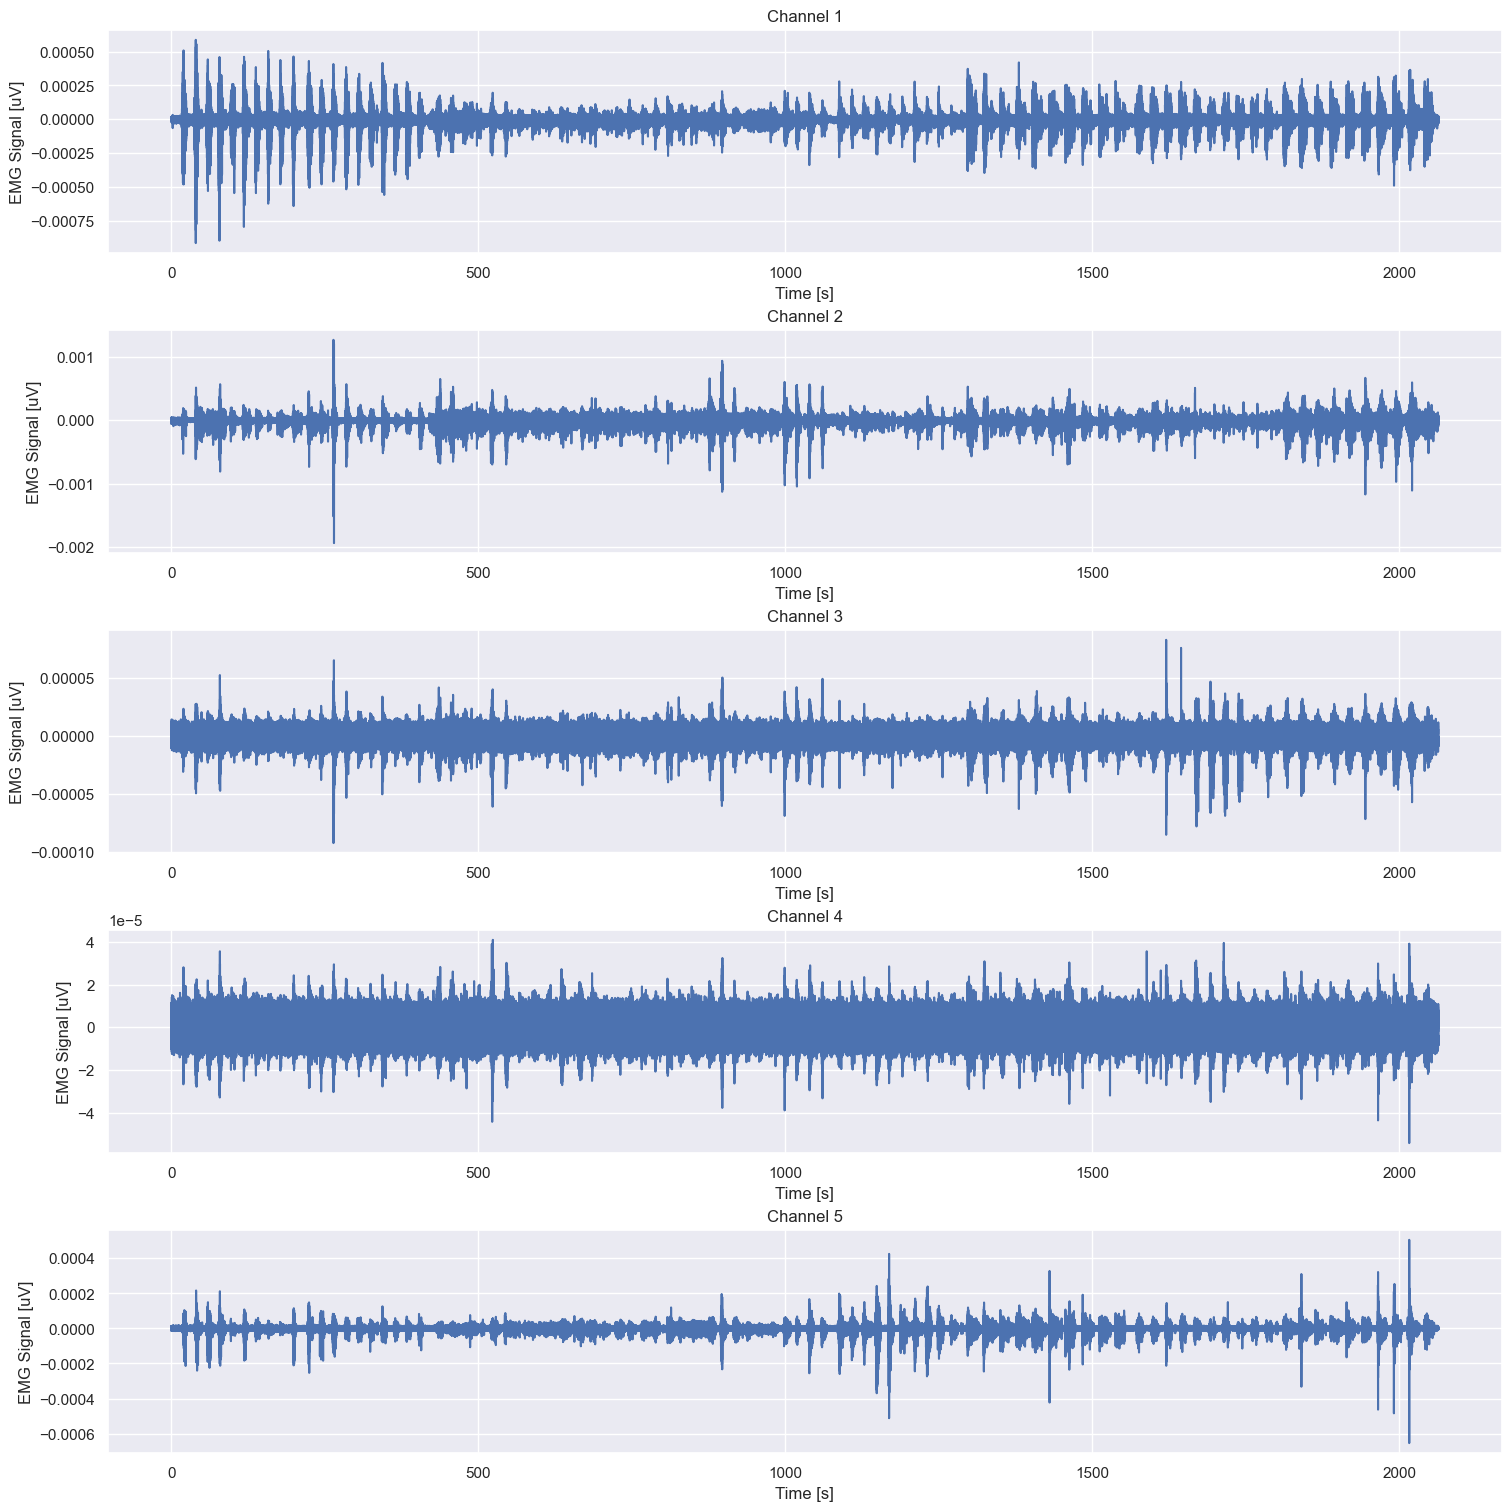

In [14]:
fs = 1111  # [Hz], from dataset description
n_channels = emg_data.shape[1]
print(f"Number of channels in the EMG data: {n_channels}")
time_steps = np.arange(emg_data.shape[0]) / fs
fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(15, 15))
for i in range(5):
    ax[i].plot(time_steps, emg_data[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")
    ax[i].set_title(f"Channel {i+1}")

We can see when the channel is picking up signals from the muscles. Let's check the signal quality to decide on the signal processing techniques.

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

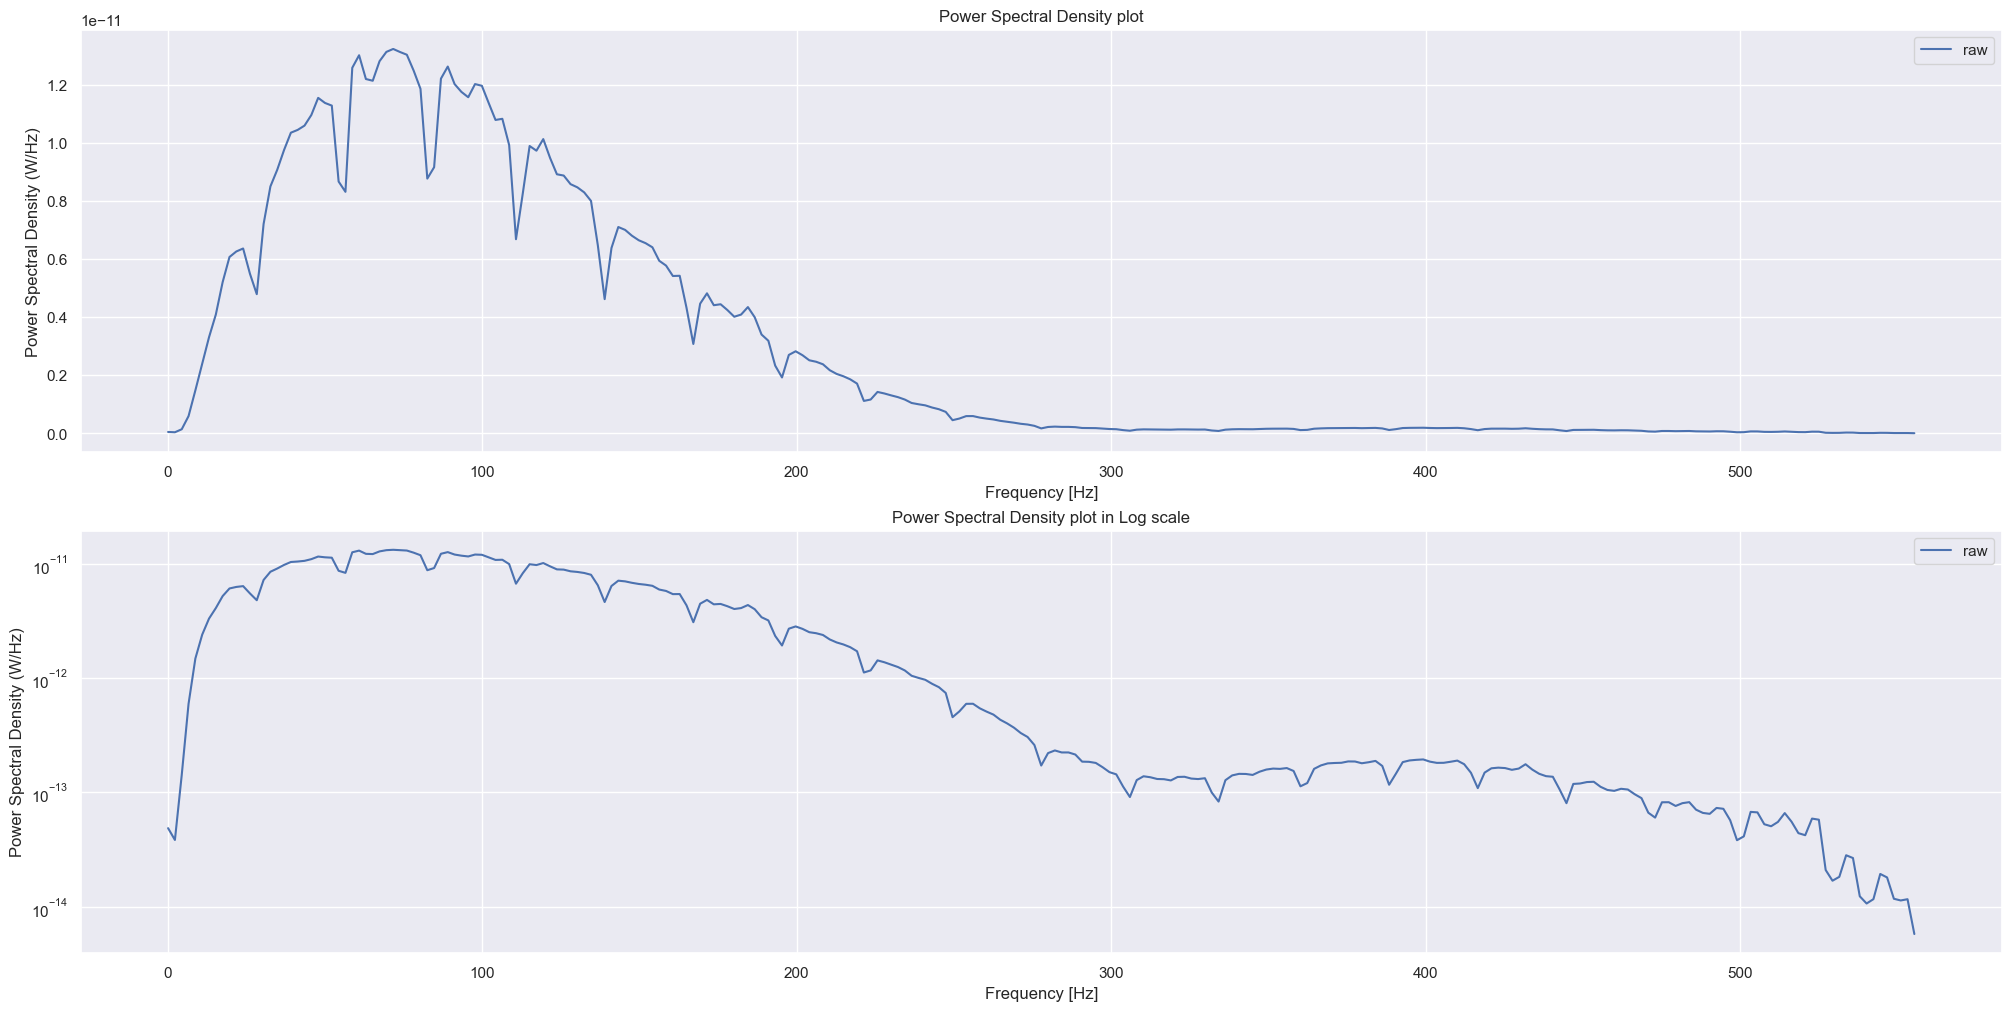

In [15]:
# Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data[:, 5], fs=fs, nperseg=512)

fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(20, 10))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

It looks like most of the harmonic frequencies of powerline noise have already been removed using a bandstop filer and that there is not much happening outside of the frequency range 0-500. So I think that the preprocessing is unuseful. 

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

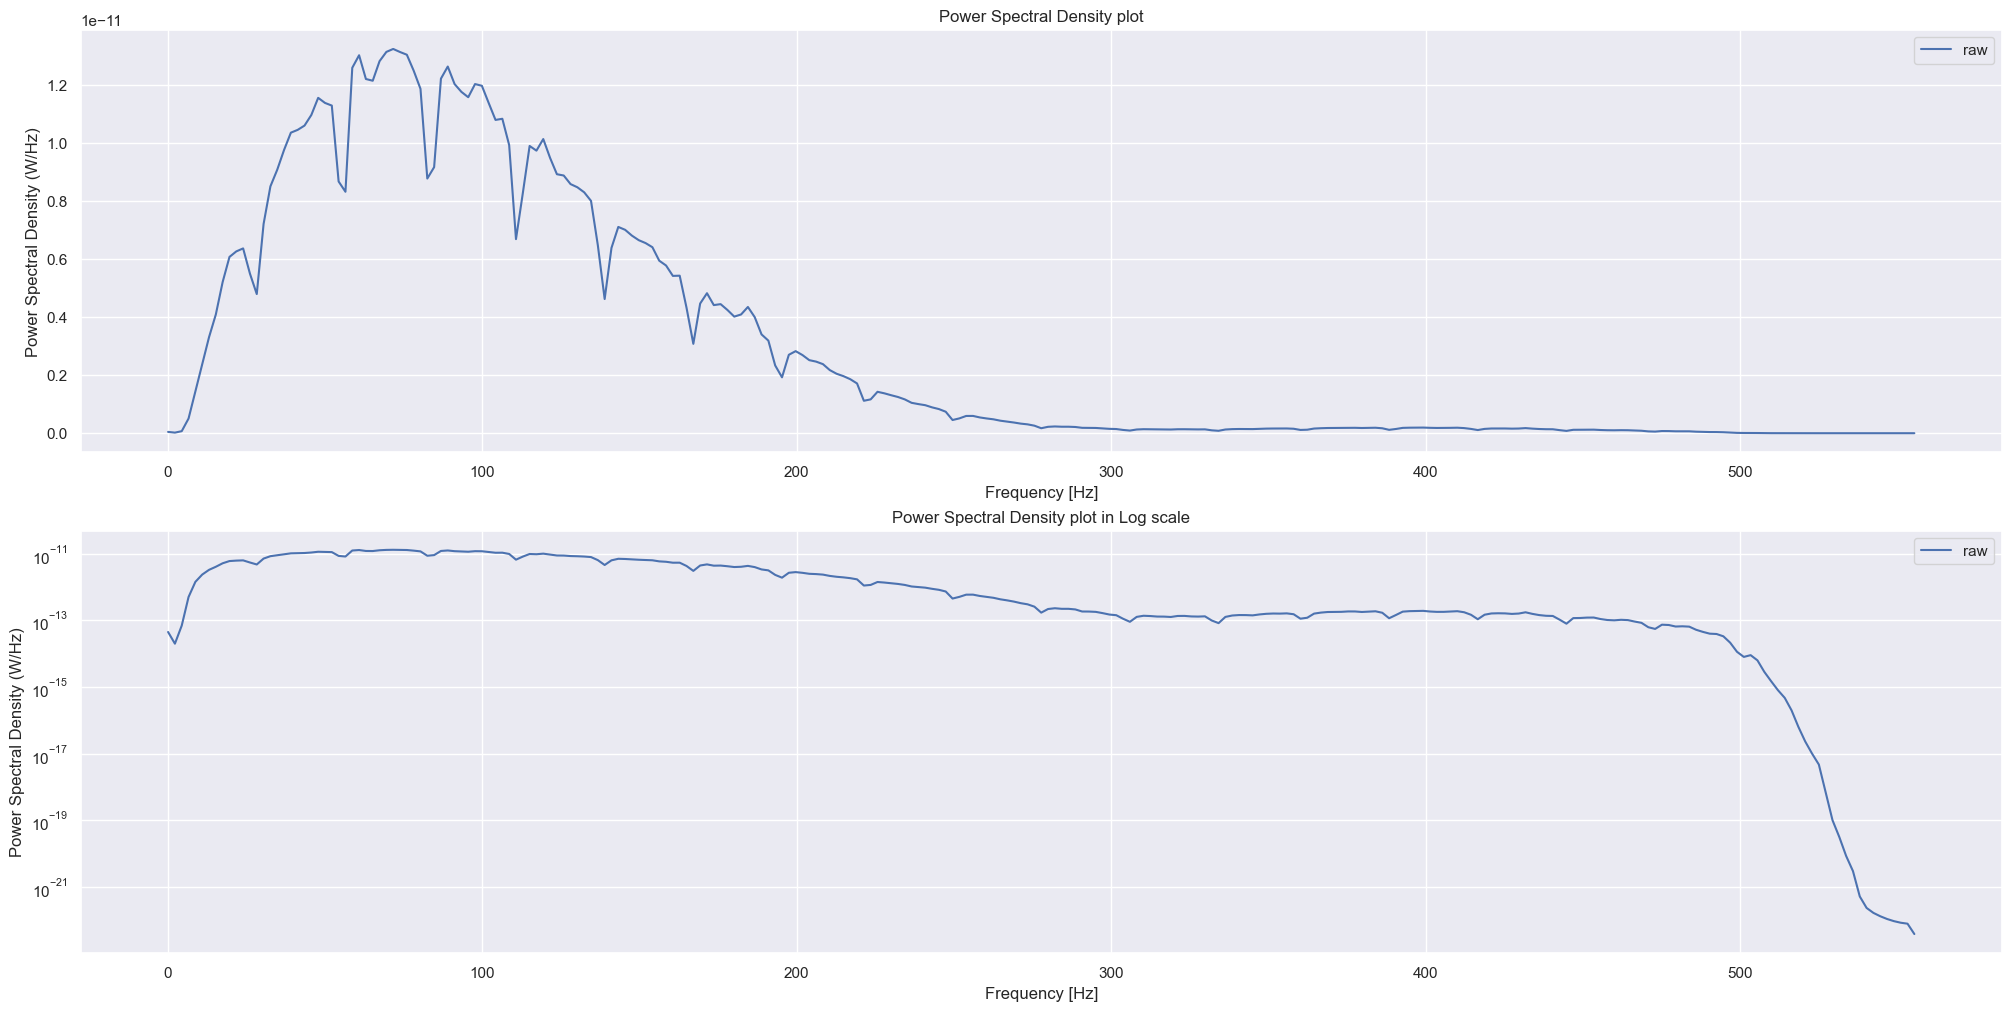

In [16]:
# Applying a bandpass butterworth filter and check power spectra density

bandpass_cutoff=(5,500)
sos = butter(N=4, Wn=bandpass_cutoff, fs=fs, btype="bandpass", output="sos")
emg_bandpassed = sosfiltfilt(sos, emg_data.T).T

freqs_pre, Pxx_pre = welch(emg_bandpassed[:, 5], fs=fs, nperseg=512)

fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(20, 10))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

But the signal still needs to be rectified:

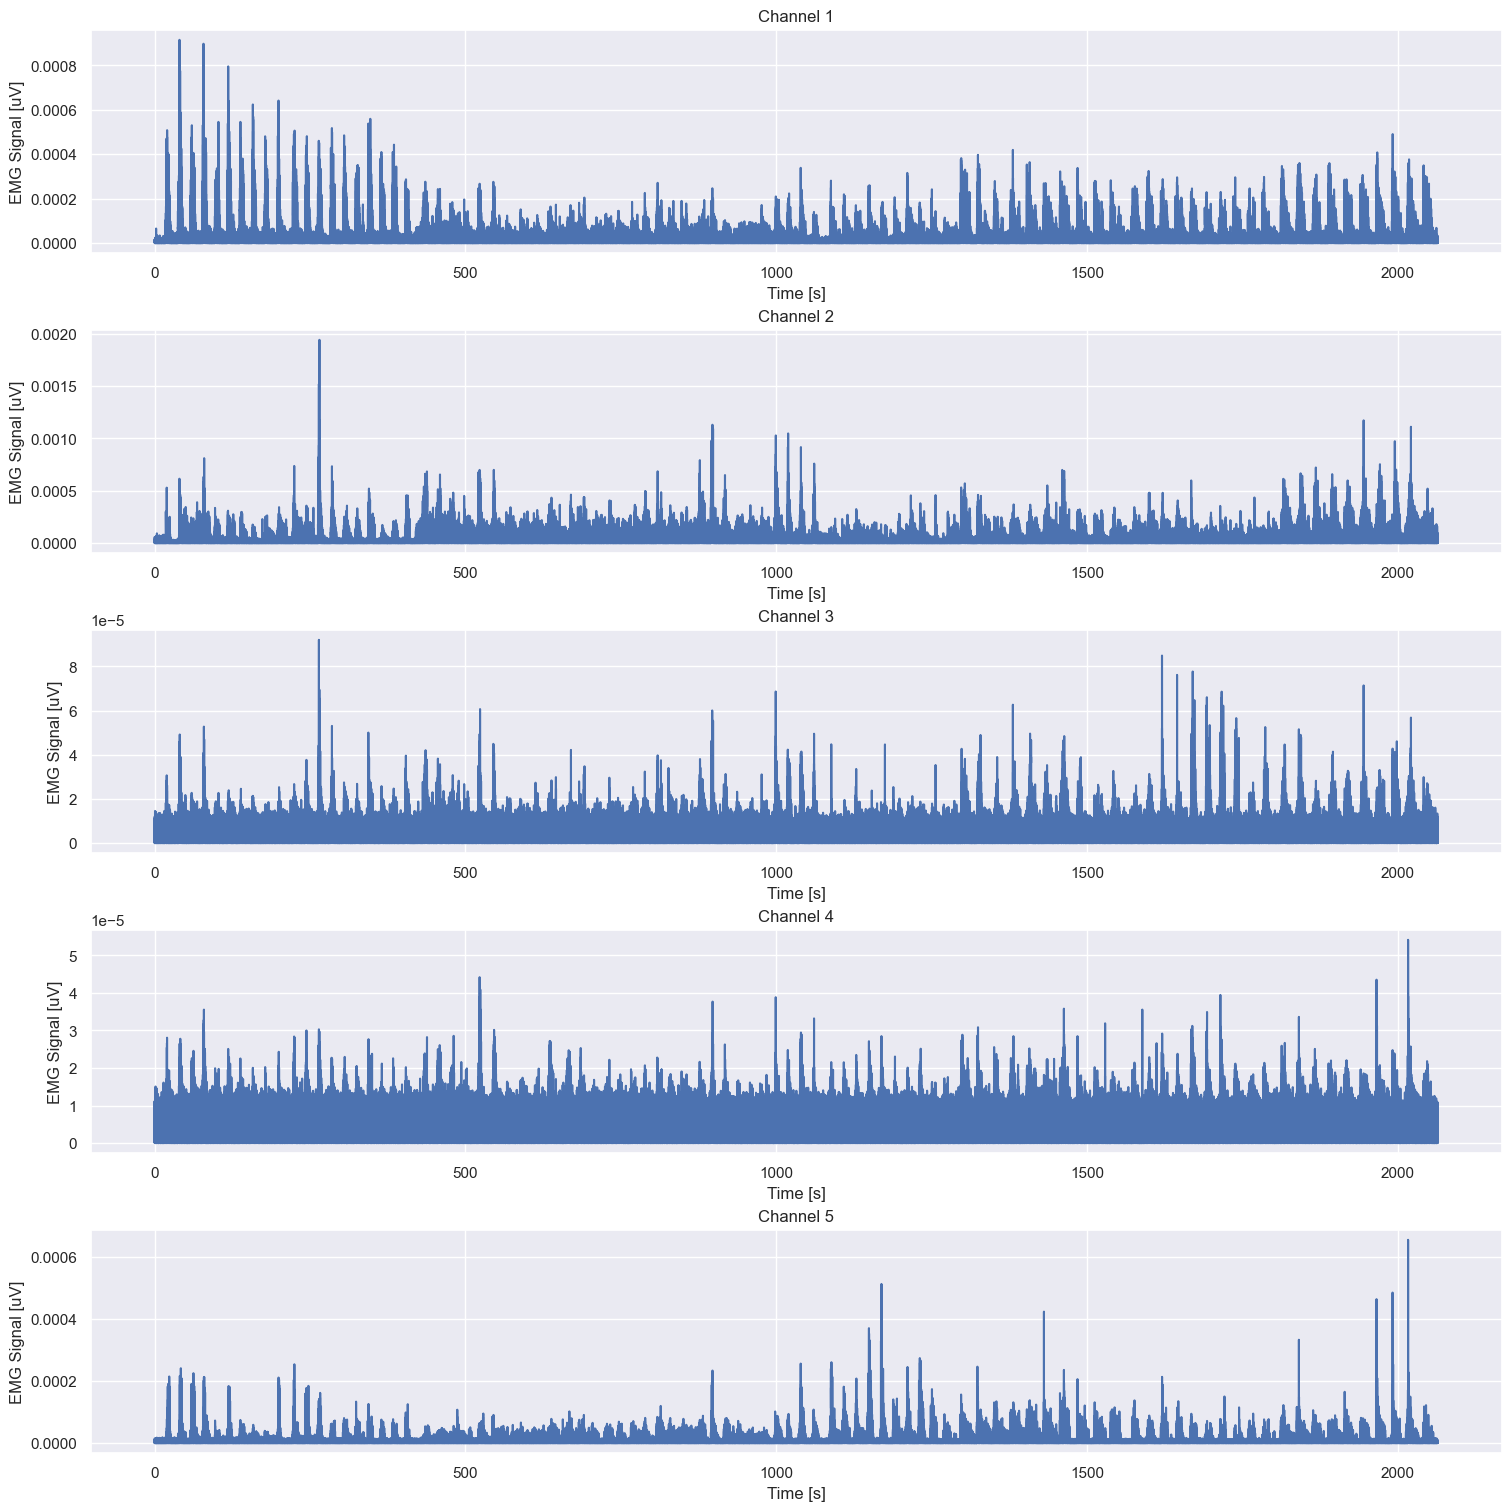

In [17]:
# Rectify signals
emg_rectified = np.abs(emg_data) # Rectify the signal

fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(15, 15))
for i in range(5):
    ax[i].plot(time_steps, emg_rectified[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")
    ax[i].set_title(f"Channel {i+1}")

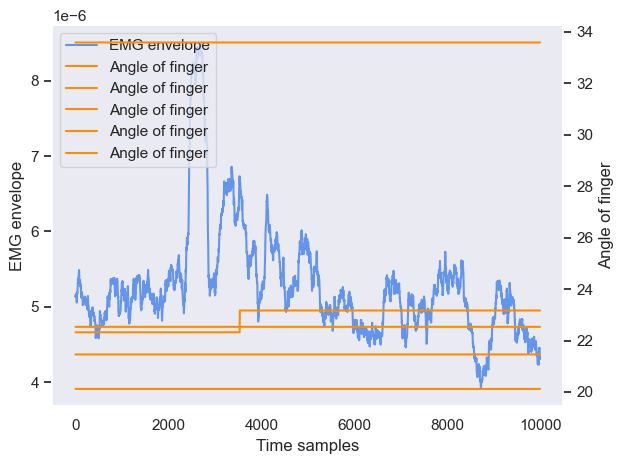

In [18]:
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots()
ax.plot(EMG_envelopes[:10000, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(glove_data_index[:10000, :], color="darkorange", label="Angle of finger")
finger_angle_ax.set_ylabel("Angle of finger")
finger_angle_ax.grid(False)

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()

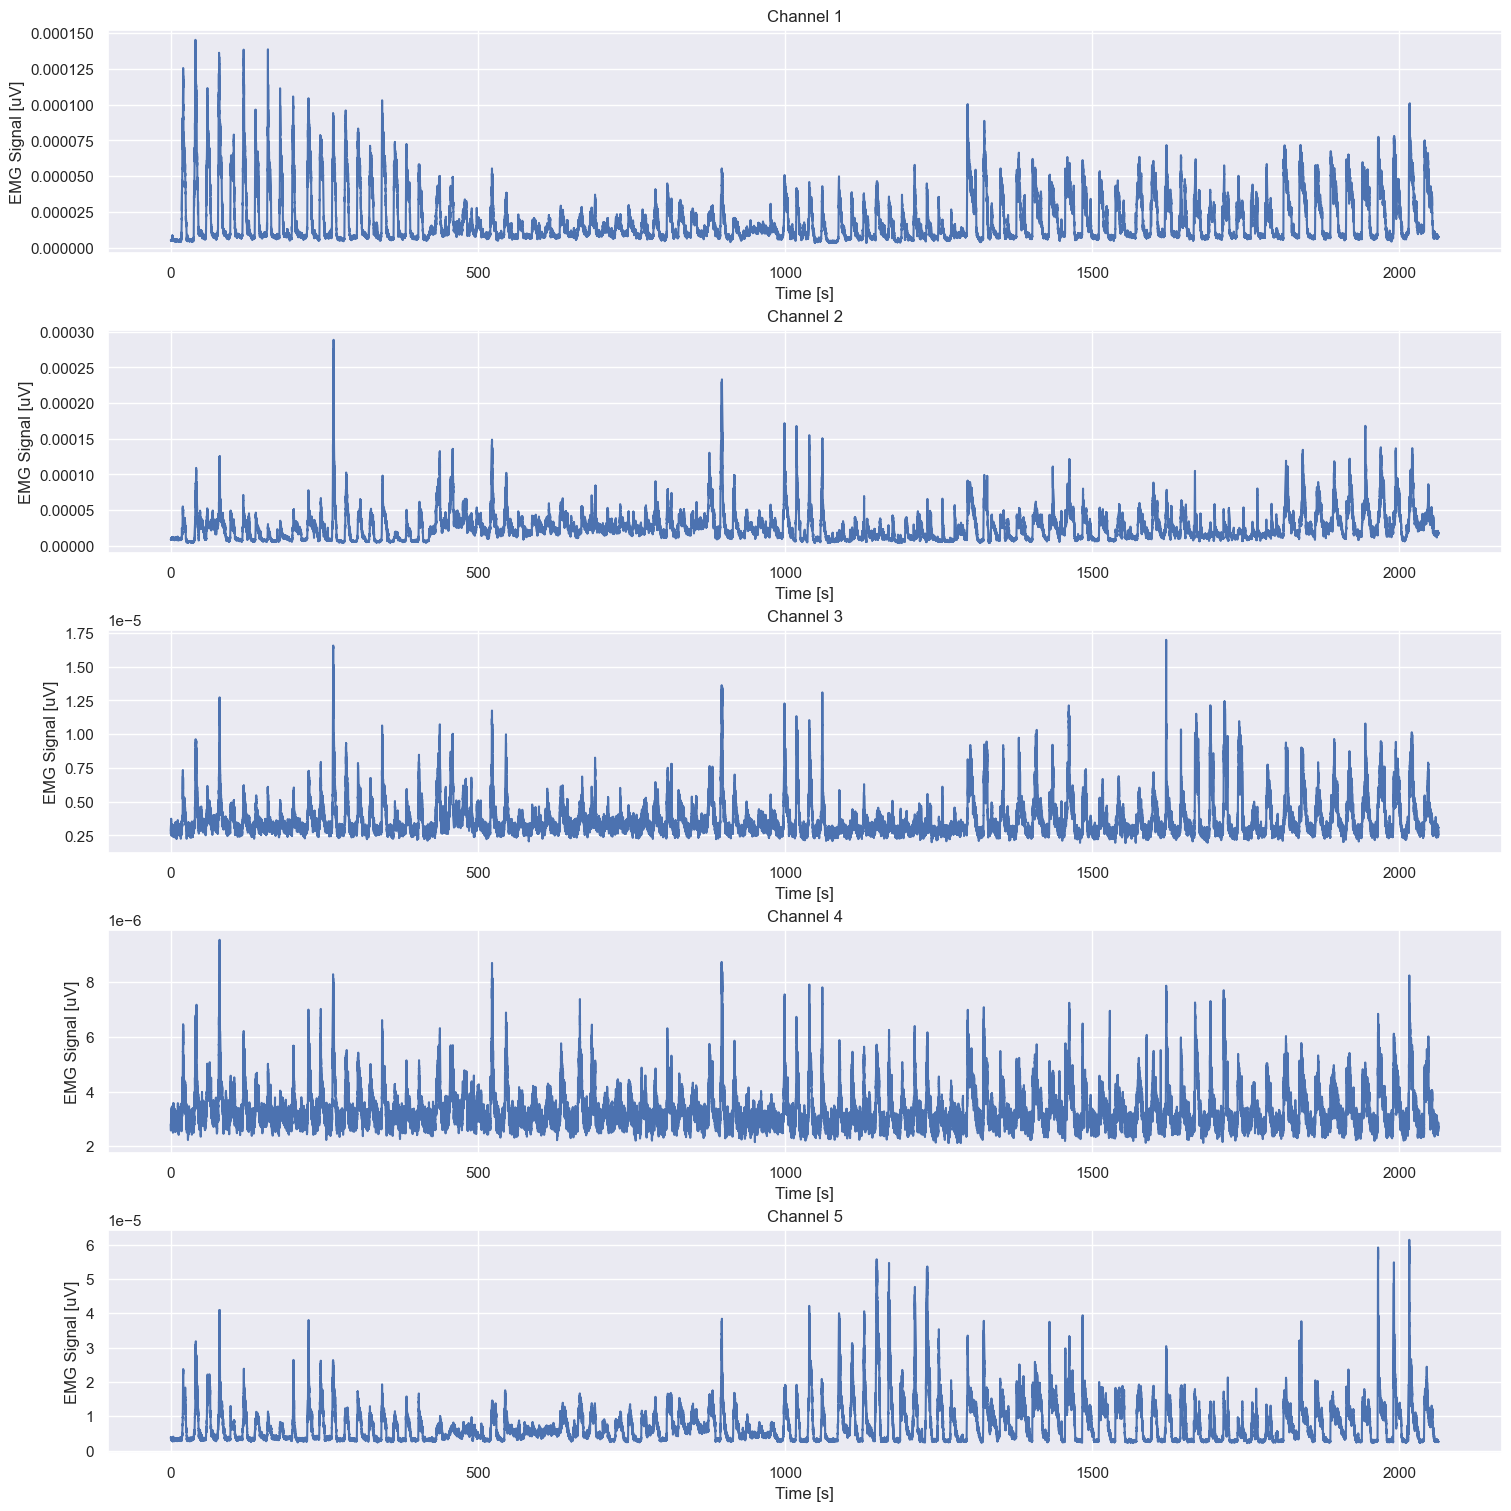

In [34]:
# Rectify signals
emg_rectified = np.abs(emg_data) # Rectify the signal

fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(15, 15))
for i in range(5):
    ax[i].plot(time_steps, EMG_envelopes[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [uV]")
    ax[i].set_title(f"Channel {i+1}")

Before going to do sliding windows, let's do the train-val-test split

# Train-val-test split

In [19]:
# Divide the dataset into three parts, so that the val set is all the repetions number 2 and 7 and the test set is all the repetions number 5
stimulus = data['restimulus']
repetition = data['rerepetition']
train_indices = np.where((repetition != 2) & (repetition != 5) & (repetition != 7))[0]
val_indices = np.where((repetition == 2) | (repetition == 7))[0]
test_indices = np.where(repetition == 5)[0]

# get EMG envelope
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0)

# get train, val, test
EMG_train = EMG_envelopes[train_indices]
Labels_train = glove_data_index[train_indices]
EMG_val = EMG_envelopes[val_indices]
Labels_val = glove_data_index[val_indices]
EMG_test = EMG_envelopes[test_indices]
Labels_test = glove_data_index[test_indices]

# Print the shapes of the resulting datasets
print("Training set EMG shape:", EMG_train.shape)
print("Training set Labels shape:", Labels_train.shape)
print("Validation set EMG shape:", EMG_val.shape)
print("Validation set Labels shape:", Labels_val.shape)
print("Test set EMG shape:", EMG_test.shape)
print("Test set Labels shape:", Labels_test.shape) 

Training set EMG shape: (1648512, 16)
Training set Labels shape: (1648512, 5)
Validation set EMG shape: (428749, 16)
Validation set Labels shape: (428749, 5)
Test set EMG shape: (215265, 16)
Test set Labels shape: (215265, 5)


# Sliding windows split

To process the dataset efficiently, we divide it into overlapping sliding windows. This approach allows us to extract smaller segments of the EMG data, each corresponding to a specific time interval. The sliding window technique ensures that we capture temporal patterns in the signal by dividing it into time segments, while maintaining continuity through overlapping segments.

In [20]:
fs = 1111  # [Hz], from dataset description
emg_window_length_sec = 128e-3  # [s]
incremental_window_length_sec = 50e-3  # [s]

print(int(emg_window_length_sec*fs))
print(int(incremental_window_length_sec*fs))

142
55


In [21]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [22]:
# extract over lapping time windows on the whole dataset before splitting the dataset into train, validation and test
EMG_windows_train, Labels_windows_train = extract_time_windows_regression(EMG_train, Labels_train, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_val, Labels_windows_val = extract_time_windows_regression(EMG_val, Labels_val, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_test, Labels_windows_test = extract_time_windows_regression(EMG_test, Labels_test, fs, emg_window_length_sec, incremental_window_length_sec)


print(f"EMG train data shape: {EMG_windows_train.shape}, Train label shape: {Labels_windows_train.shape}")
print(f"EMG validation data shape: {EMG_windows_val.shape}, Validation label shape: {Labels_windows_val.shape}")
print(f"EMG test data shape: {EMG_windows_test.shape}, Test label shape: {Labels_windows_test.shape}")

EMG train data shape: (29971, 142, 16), Train label shape: (29971, 142, 5)
EMG validation data shape: (7793, 142, 16), Validation label shape: (7793, 142, 5)
EMG test data shape: (3912, 142, 16), Test label shape: (3912, 142, 5)


# Feature extraction for regressor

Now that we have the windows, lets extract some features again. For this exercise, we will just look at the simple features: mean, std and max amplitude of the windows.

In [25]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean, the standard deviation and the maximum amplitude of each window and the mean of the labels window
    """


    
    # # along axis 1, which is the time axis
    # EMG_mean = np.mean(EMG_windows,axis=1)
    # EMG_std = np.std(EMG_windows,axis=1)
    # EMG_max_amplitude = np.max(EMG_windows, axis=1)
    # # # Waveform length (WL)
    # #EMG_wl = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1)
    # # # Slope sign changes (SSC)
    # #EMG_ssc = np.sum(np.logical_and(np.diff(EMG_windows, axis=1)[:, :-1] * np.diff(EMG_windows, axis=1)[:, 1:] < 0, True), axis=1)
    
    # Labels_mean = np.mean(Labels_windows,axis=1)
    
    # # Concatenate the mean and std of each window
    # EMG_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude), axis=1)
    # return EMG_extracted_features, Labels_mean



    # EMG_windows is of shape (#samples, #time-points in a single window, #channels)
    # Parameters
    wa_threshold = 0.01
    ssc_threshold = 0.01
    ar_order = 4
    
    # --- 1. Mean ---
    mean_feature = np.mean(EMG_windows, axis=1)  # (20000, 16)
    
    # --- 2. Std ---
    std_feature = np.std(EMG_windows, axis=1)
    
    # --- 3. Max Amplitude ---
    max_feature = np.max(np.abs(EMG_windows), axis=1)
    
    # --- 4. Wilson Amplitude (vectorized) ---
    wa_feature = np.sum(np.abs(np.diff(EMG_windows, axis=1)) > wa_threshold, axis=1)
    
    # --- 5. Waveform Length ---
    wl_feature = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1)
    
    # --- 6. Log-Variance ---
    logvar_feature = np.log(np.var(EMG_windows, axis=1) + 1e-10)  # stability
    
    # --- 7. Slope Sign Change (vectorized) ---
    x_prev = EMG_windows[:, :-2, :]
    x_curr = EMG_windows[:, 1:-1, :]
    x_next = EMG_windows[:, 2:, :]
    ssc_feature = np.sum(((x_curr - x_prev) * (x_curr - x_next)) > ssc_threshold, axis=1)
    
    # --- 8. 4th-Order Auto-Regressive Coefficients ---
    # Initialize array (samples, channels, 4)
    ar_feature = np.zeros((EMG_windows.shape[0], EMG_windows.shape[2], ar_order))
    
    # Compute AR coefficients per window per channel
    for ch in range(EMG_windows.shape[2]):
        for w in range(EMG_windows.shape[0]):
            rho, sigma = yule_walker(EMG_windows[w, :, ch], order=ar_order)
            ar_feature[w, ch, :] = rho
    
    # Flatten AR coefficients to concatenate
    ar_feature_flat = ar_feature.reshape(EMG_windows.shape[0], -1)  # (samples, channels*4=64)
    
    # --- Concatenate all features ---
    features = np.concatenate([
        mean_feature, std_feature, max_feature, wa_feature,
        wl_feature, logvar_feature, ssc_feature, ar_feature_flat
    ], axis=1)

    # get ground truth labels by calculating mean over the windows
    Labels_mean = np.mean(Labels_windows,axis=1)

    # return features and labels for ML model
    return features, Labels_mean


In [26]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_windows_train,Labels_windows_train)
EMG_val_extracted_features, Labels_val_mean = extract_features(EMG_windows_val,Labels_windows_val)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_windows_test,Labels_windows_test)

print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG val extracted features shape: {}, Finger labels feature shape:{}".format(EMG_val_extracted_features.shape, Labels_val_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

EMG train extracted features shape: (29971, 176), Finger labels feature shape:(29971, 5)
EMG val extracted features shape: (7793, 176), Finger labels feature shape:(7793, 5)
EMG test extracted features shape: (3912, 176), Finger labels feature shape:(3912, 5)


Total features: 7 + 4 (AR) = 11. <br>
We have a total of 176 features -> 16 channels * 11 features for each channel.

In [27]:
# Normalize the features
scaler = StandardScaler()
scaler.fit(EMG_train_extracted_features) #use mean and std from the train set
EMG_train_scaled = scaler.transform(EMG_train_extracted_features)
EMG_val_scaled = scaler.transform(EMG_val_extracted_features)
EMG_test_scaled = scaler.transform(EMG_test_extracted_features)

# Visualize the correlation between features

# Convert to DataFrame for convenience
df_train = pd.DataFrame(EMG_train_scaled, columns=[f"Feature {i}" for i in range(EMG_train_scaled.shape[1])])

df=df_train
# Check which features have NaNs
nan_features = df.columns[df.isna().any()].tolist()
print("Features with NaNs:", nan_features)

# Check which features are constant (zero variance)
constant_features = df.columns[df.nunique() <= 1].tolist()
print("Constant features:", constant_features)

# Optional: check for infinite values
inf_features = df.columns[(df == np.inf).any() | (df == -np.inf).any()].tolist()
print("Features with infinities:", inf_features)


Features with NaNs: []
Constant features: ['Feature 48', 'Feature 49', 'Feature 50', 'Feature 51', 'Feature 52', 'Feature 53', 'Feature 54', 'Feature 55', 'Feature 56', 'Feature 57', 'Feature 58', 'Feature 59', 'Feature 60', 'Feature 61', 'Feature 62', 'Feature 63', 'Feature 96', 'Feature 97', 'Feature 98', 'Feature 99', 'Feature 100', 'Feature 101', 'Feature 102', 'Feature 103', 'Feature 104', 'Feature 105', 'Feature 106', 'Feature 107', 'Feature 108', 'Feature 109', 'Feature 110', 'Feature 111']
Features with infinities: []


In [28]:
# val and test dataframes
df_train = pd.DataFrame(EMG_train_scaled, columns=[f"Feature {i}" for i in range(EMG_train_scaled.shape[1])])
df_val = pd.DataFrame(EMG_val_scaled, columns=[f"Feature {i}" for i in range(EMG_train_scaled.shape[1])])
df_test = pd.DataFrame(EMG_test_scaled, columns=[f"Feature {i}" for i in range(EMG_train_scaled.shape[1])])

# Check which features are constant (zero variance)
constant_features = df_train.columns[df_train.nunique() <= 1].tolist()
print("Constant features:", constant_features)

# drop constant features
df_train = df_train.drop(columns=constant_features)
df_val = df_val.drop(columns=constant_features)
df_test = df_test.drop(columns=constant_features)


Constant features: ['Feature 48', 'Feature 49', 'Feature 50', 'Feature 51', 'Feature 52', 'Feature 53', 'Feature 54', 'Feature 55', 'Feature 56', 'Feature 57', 'Feature 58', 'Feature 59', 'Feature 60', 'Feature 61', 'Feature 62', 'Feature 63', 'Feature 96', 'Feature 97', 'Feature 98', 'Feature 99', 'Feature 100', 'Feature 101', 'Feature 102', 'Feature 103', 'Feature 104', 'Feature 105', 'Feature 106', 'Feature 107', 'Feature 108', 'Feature 109', 'Feature 110', 'Feature 111']


In [29]:
df_train.shape, df_val.shape, df_test.shape

((29971, 144), (7793, 144), (3912, 144))

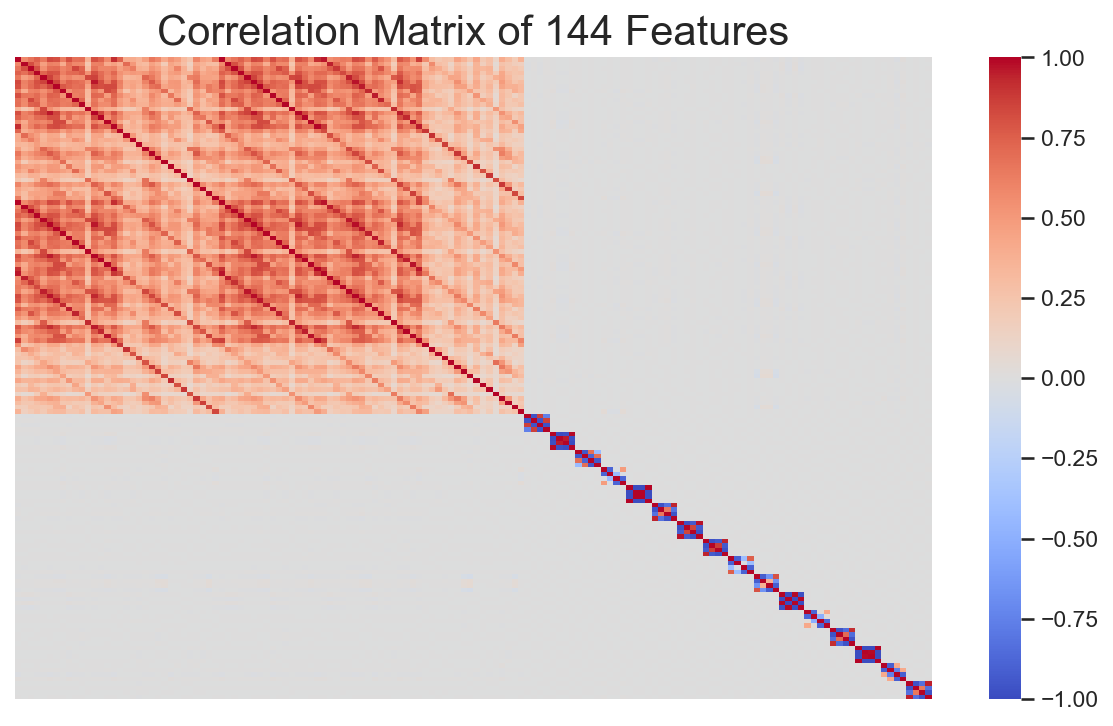

In [30]:
# Compute correlation matrix
corr_matrix = df_train.corr()

plt.figure(figsize=(8, 5), dpi=150)  # large figure and high resolution
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    cbar=True,
    xticklabels=False,  # hide x labels
    yticklabels=False,  # hide y labels
    linewidths=0,       # remove gaps
    linecolor=None       # no lines
)

plt.title("Correlation Matrix of 144 Features", fontsize=20)
plt.tight_layout()
plt.show()

In [116]:
# the grey ones are autocorelated features!! (80-144 column number)

### PCA Analysis

In [146]:
# Use PCA for dimensionality reduction

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume X is your dataframe or numpy array with shape (n_samples, 144)
# If it's a dataframe:
# X = your_dataframe.values

X_train_scaled = df_train
X_val_scaled = df_val
X_test_scaled = df_test

# Fit PCA
n_components = 50
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train_scaled)

# Transform using training PCA
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Optional: explained variance
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_variance_ratio)
print("Total variance explained by top 20 components:", explained_variance_ratio.sum())

# Convert to DataFrame for training
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
print(X_pca_df.shape)  # Should be (n_samples, 20)

# Now you can use X_pca_df for training your model


Explained variance by each component: [0.27252146 0.03919116 0.03180514 0.02785038 0.02767059 0.02759734
 0.02739315 0.0266688  0.02651683 0.02634403 0.0256214  0.02518096
 0.02502969 0.02494771 0.02299303 0.02213081 0.0192919  0.01909565
 0.01894314 0.01616423 0.01445831 0.01438782 0.01380812 0.01347602
 0.01329148 0.01143181 0.01076051 0.01011566 0.00983989 0.00877905
 0.00866081 0.0082407  0.00761139 0.00691815 0.006502   0.00571766
 0.0052712  0.00517738 0.00498088 0.00477531 0.00445598 0.00412306
 0.0037195  0.0034878  0.00289843 0.00278404 0.0027505  0.00261032
 0.00251438 0.00239988]
Total variance explained by top 20 components: 0.9689054715277211
(29971, 50)


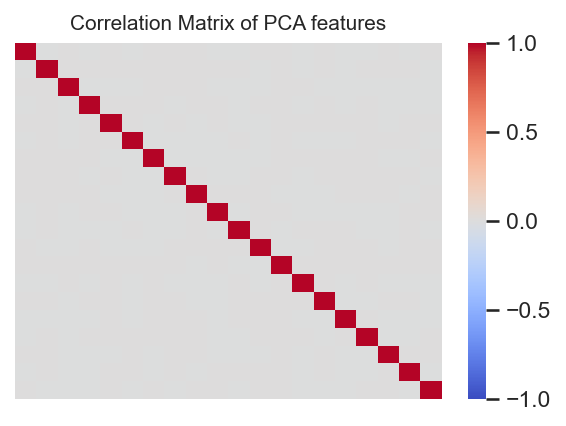

In [125]:
# Compute correlation matrix
corr_matrix = X_pca_df.corr()

plt.figure(figsize=(4,3), dpi=150)  # large figure and high resolution
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    cbar=True,
    xticklabels=False,  # hide x labels
    yticklabels=False,  # hide y labels
    linewidths=0,       # remove gaps
    linecolor=None       # no lines
)

plt.title("Correlation Matrix of PCA features", fontsize=10)
plt.tight_layout()
plt.show()

In [131]:
X_pca.shape, X_val_pca.shape, X_test_pca.shape

((29971, 20), (7793, 20), (3912, 20))

In [133]:
Labels_train_mean.shape

(29971, 5)

In [154]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error

# # Create SVR model
# svr = SVR(kernel='linear', verbose=True)  # linear SVR
# multi_svr = MultiOutputRegressor(svr)

# # Train on training data
# multi_svr.fit(X_pca, Labels_train_mean)


# for all 144 scaled features, use X_train_scaled

# It is highly recommended to scale features for SVMs
svm_regressor = MultiOutputRegressor(
    make_pipeline(StandardScaler(), SVR(kernel='linear', verbose=True))
)

#Fit and predict using the SVM regressor
svm_regressor.fit(X_train_scaled, Labels_train_mean)
#svm_regressor.fit(X_train_scaled, Labels_train_mean)

[LibSVM].........................................................................................................................................................................................................................................................................................................*...............................................*.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*................................................

MultiOutputRegressor(estimator=Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('svr',
                                                SVR(kernel='linear',
                                                    verbose=True))]))

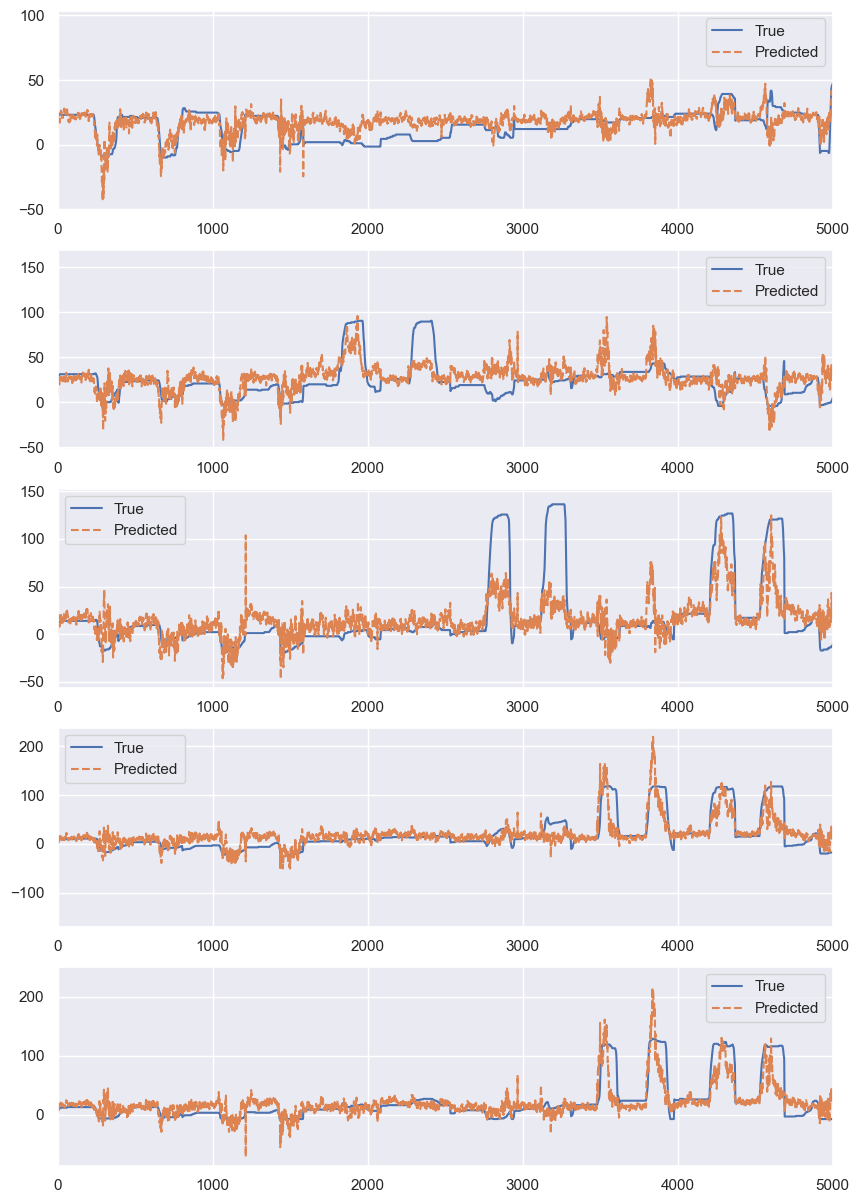

In [158]:
# Plot the true and predicted values for all finger angles - VAL set
fig, ax = plt.subplots(5, 1, figsize=(10, 15))
for i in range(5):
    ax[i].plot(Labels_val_mean[:,i], label="True")
    ax[i].plot(y_val_pred[:,i], linestyle="--", label="Predicted")
    ax[i].set_xlim(0, 5000)
    ax[i].legend()

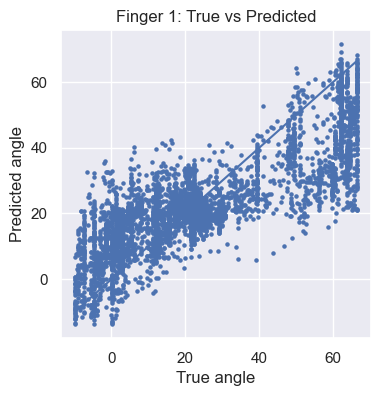

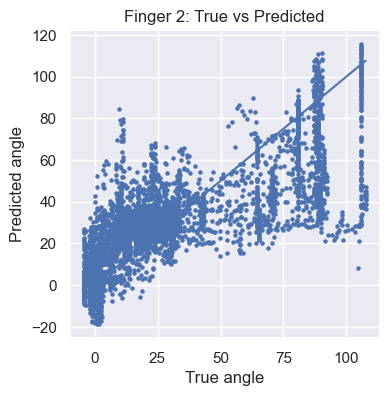

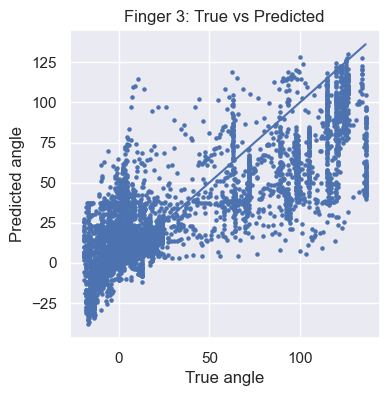

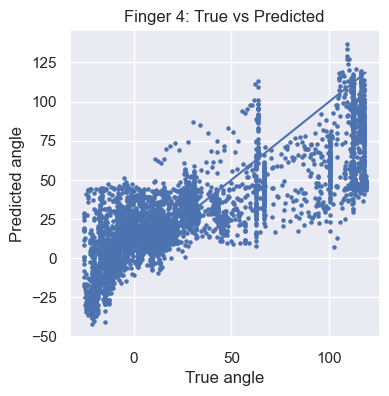

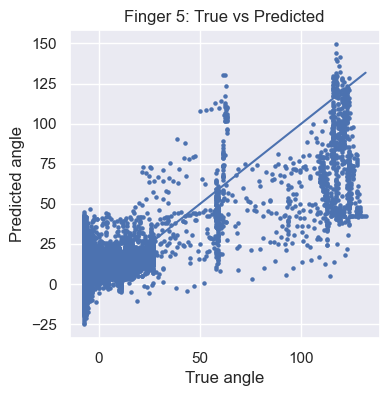

In [27]:
# import matplotlib.pyplot as plt

# for i in range(5):
#     plt.figure(figsize=(4,4))
#     plt.scatter(Labels_val_mean[:, i], y_pred_val_svm_rbf[:, i], s=5)
#     plt.xlabel("True angle")
#     plt.ylabel("Predicted angle")
#     plt.title(f"Finger {i+1}: True vs Predicted")
#     plt.plot([Labels_val_mean[:, i].min(), Labels_val_mean[:, i].max()],
#              [Labels_val_mean[:, i].min(), Labels_val_mean[:, i].max()])
#     plt.show()

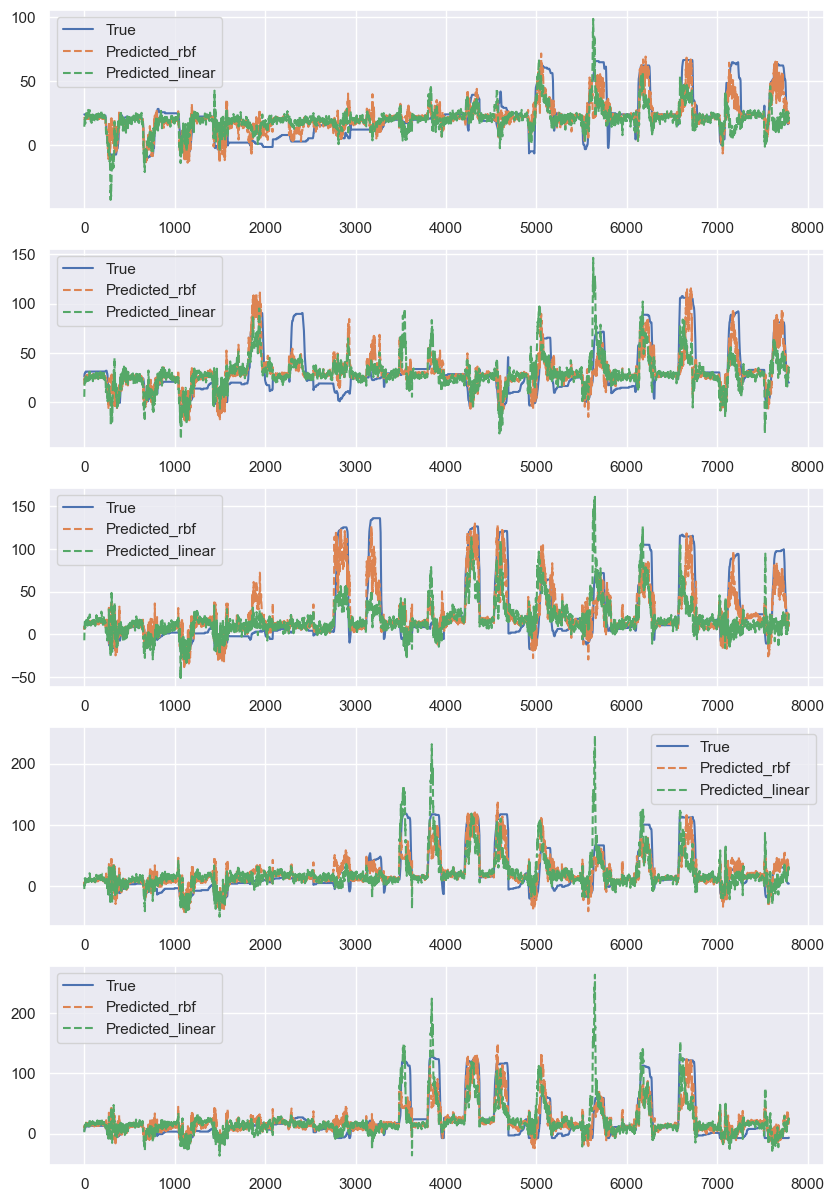

In [32]:
# Plot the true and predicted values for all finger angles
fig, ax = plt.subplots(5, 1, figsize=(10, 15))
for i in range(5):
    ax[i].plot(Labels_val_mean[:,i], label="True")
    ax[i].plot(y_pred_val_svm_rbf[:,i], linestyle="--", label="Predicted_rbf")
    ax[i].plot(y_pred_val_svm[:,i], linestyle="--", label="Predicted_linear")
    ax[i].legend()

In [35]:
from sklearn.metrics import mean_squared_error

mse_each = mean_squared_error(Labels_val_mean, y_pred_val_svm_rbf, multioutput='raw_values')
print("MSE per finger:", mse_each)

mse_mean = mean_squared_error(Labels_val_mean, y_pred_val_svm_rbf)
print("Mean MSE:", mse_mean)

MSE per finger: [114.48289186 280.31009575 526.30306173 422.85637506 450.58230836]
Mean MSE: 358.9069465510828


In [37]:
from sklearn.metrics import mean_squared_error

mse_each = mean_squared_error(Labels_val_mean, y_pred_val_svm, multioutput='raw_values')
print("MSE per finger:", mse_each)

mse_mean = mean_squared_error(Labels_val_mean, y_pred_val_svm)
print("Mean MSE:", mse_mean)

MSE per finger: [ 211.10599425  412.99453689 1056.36971597  664.88473511  659.45309033]
Mean MSE: 600.9616145104056


In [39]:
from sklearn.metrics import r2_score

mse_each = r2_score(Labels_val_mean, y_pred_val_svm_rbf, multioutput='raw_values')
print("MSE per finger:", mse_each)

mse_mean = r2_score(Labels_val_mean, y_pred_val_svm_rbf)
print("Mean MSE:", mse_mean)

MSE per finger: [0.62509053 0.54436362 0.65204127 0.65801478 0.65123744]
Mean MSE: 0.6261495262970435


In [38]:
from sklearn.metrics import r2_score

mse_each = r2_score(Labels_val_mean, y_pred_val_svm, multioutput='raw_values')
print("MSE per finger:", mse_each)

mse_mean = r2_score(Labels_val_mean, y_pred_val_svm)
print("Mean MSE:", mse_mean)

MSE per finger: [0.30866843 0.3286887  0.3015943  0.46227427 0.48956595]
Mean MSE: 0.3781583283078622


# Hyperparameter tuning

In [32]:
X_train_scaled = df_train
X_val_scaled = df_val
X_test_scaled = df_test

x_train = X_train_scaled
y_train = Labels_train_mean
x_val = X_val_scaled
y_val = Labels_val_mean

In [33]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((29971, 144), (29971, 5), (7793, 144), (7793, 5))

In [39]:
# 1. Define grid
param_grid = {
    "svr__kernel": ["linear", "rbf"],
    "svr__C": [0.01, 0.1, 1, 10, 100],
    "svr__gamma": ["scale", "auto"]
}

# 2. Generate combinations
grid = list(ParameterGrid(param_grid))
print("Total configurations:", len(grid))

results = []

# 3. Grid search loop (manual, since we use val set)
for i, params in enumerate(grid, 1):

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR())
    ])
    
    # Set parameters
    pipeline.set_params(**params)

    model = MultiOutputRegressor(pipeline, n_jobs=-1)

    # Fit
    model.fit(x_train, y_train)

    # Predict
    y_val_pred = model.predict(x_val)

    # MSE
    mse = mean_squared_error(y_val, y_val_pred)

    results.append((mse, params))
    print(f"[{i}/{len(grid)}] MSE={mse:.6f} | {params}")

# 4. Best result
results_sorted = sorted(results, key=lambda x: x[0])
best_mse, best_params = results_sorted[0]

print("\nBest configuration:")
print("MSE =", best_mse)
print(best_params)


Total configurations: 20
[1/20] MSE=596.661903 | {'svr__C': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}


Exception ignored in: <function ResourceTracker.__del__ at 0x102870040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102ea0040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function 

[2/20] MSE=1028.120268 | {'svr__C': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


Exception ignored in: <function ResourceTracker.__del__ at 0x1047fc040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[3/20] MSE=596.661903 | {'svr__C': 0.01, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}


Exception ignored in: <function ResourceTracker.__del__ at 0x1078d8040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[4/20] MSE=1028.120268 | {'svr__C': 0.01, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}


Exception ignored in: <function ResourceTracker.__del__ at 0x104840040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107ab8040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function 

[5/20] MSE=572.665529 | {'svr__C': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}


Exception ignored in: <function ResourceTracker.__del__ at 0x10986c040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[6/20] MSE=787.286275 | {'svr__C': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


Exception ignored in: <function ResourceTracker.__del__ at 0x11116c040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[7/20] MSE=572.665529 | {'svr__C': 0.1, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}
[8/20] MSE=787.286275 | {'svr__C': 0.1, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
[9/20] MSE=568.926018 | {'svr__C': 1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
[10/20] MSE=403.712088 | {'svr__C': 1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
[11/20] MSE=568.926018 | {'svr__C': 1, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}


Exception ignored in: <function ResourceTracker.__del__ at 0x104174040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[12/20] MSE=403.712088 | {'svr__C': 1, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}


Exception ignored in: <function ResourceTracker.__del__ at 0x1074a8040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1066f0040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function 

[13/20] MSE=568.973173 | {'svr__C': 10, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
[14/20] MSE=297.092201 | {'svr__C': 10, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


Exception ignored in: <function ResourceTracker.__del__ at 0x1037c4040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1102bc040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function 

[15/20] MSE=568.973173 | {'svr__C': 10, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}
[16/20] MSE=297.092201 | {'svr__C': 10, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}


Exception ignored in: <function ResourceTracker.__del__ at 0x102f6c040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105500040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function 

[17/20] MSE=570.427063 | {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}


Exception ignored in: <function ResourceTracker.__del__ at 0x102284040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102dbc040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function 

[18/20] MSE=261.860892 | {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


Exception ignored in: <function ResourceTracker.__del__ at 0x1041e4040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1045d8040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/mlproj/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function 

KeyboardInterrupt: 

Optimal -> [18/20] MSE=261.860892 | {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}

# Train final model

In [41]:
# Train the optimal model (final model to be used for inference)

from sklearn.pipeline import make_pipeline

# It is highly recommended to scale features for SVMs
final_svm_regressor = MultiOutputRegressor(
    make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma="scale", verbose=True))
)

#Fit and predict using the SVM regressor
final_svm_regressor.fit(X_train_scaled, Labels_train_mean)
#svm_regressor.fit(X_train_scaled, Labels_train_mean)


[LibSVM].............................................................................................................................................................................*...........................................................................*
optimization finished, #iter = 248715
obj = -12179640.490997, rho = -21.213054
nSV = 29288, nBSV = 24285
..................................................................................................................................*....................................................*.............*
optimization finished, #iter = 194581
obj = -20493898.396240, rho = -35.107738
nSV = 29496, nBSV = 25088
................................................................................................................*....................................*
optimization finished, #iter = 148799
obj = -27981960.606027, rho = -34.471140
nSV = 29622, nBSV = 25686
............................................................................

MultiOutputRegressor(estimator=Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('svr',
                                                SVR(C=100, verbose=True))]))

# Evaluate final model

In [43]:
# Predict on test set
y_test_pred = final_svm_regressor.predict(X_test_scaled)
# Compute Mean Squared Error
mse_test = mean_squared_error(Labels_test_mean, y_test_pred)
print("Test Set MSE:", mse_test)
var_y = np.var(Labels_test_mean)
r2 = 1 - mse_test / var_y
print("Test Set R^2:", r2)

# Predict on val set
y_val_pred = final_svm_regressor.predict(X_val_scaled)
# Compute Mean Squared Error
mse_val = mean_squared_error(Labels_val_mean, y_val_pred)
print("Val Set MSE:", mse_val)
var_y = np.var(Labels_val_mean)
r2 = 1 - mse_val / var_y
print("Val Set R^2:", r2)

Test Set MSE: 258.76856358163406
Test Set R^2: 0.767057960299064
Val Set MSE: 261.8608916448449
Val Set R^2: 0.7389898832778774


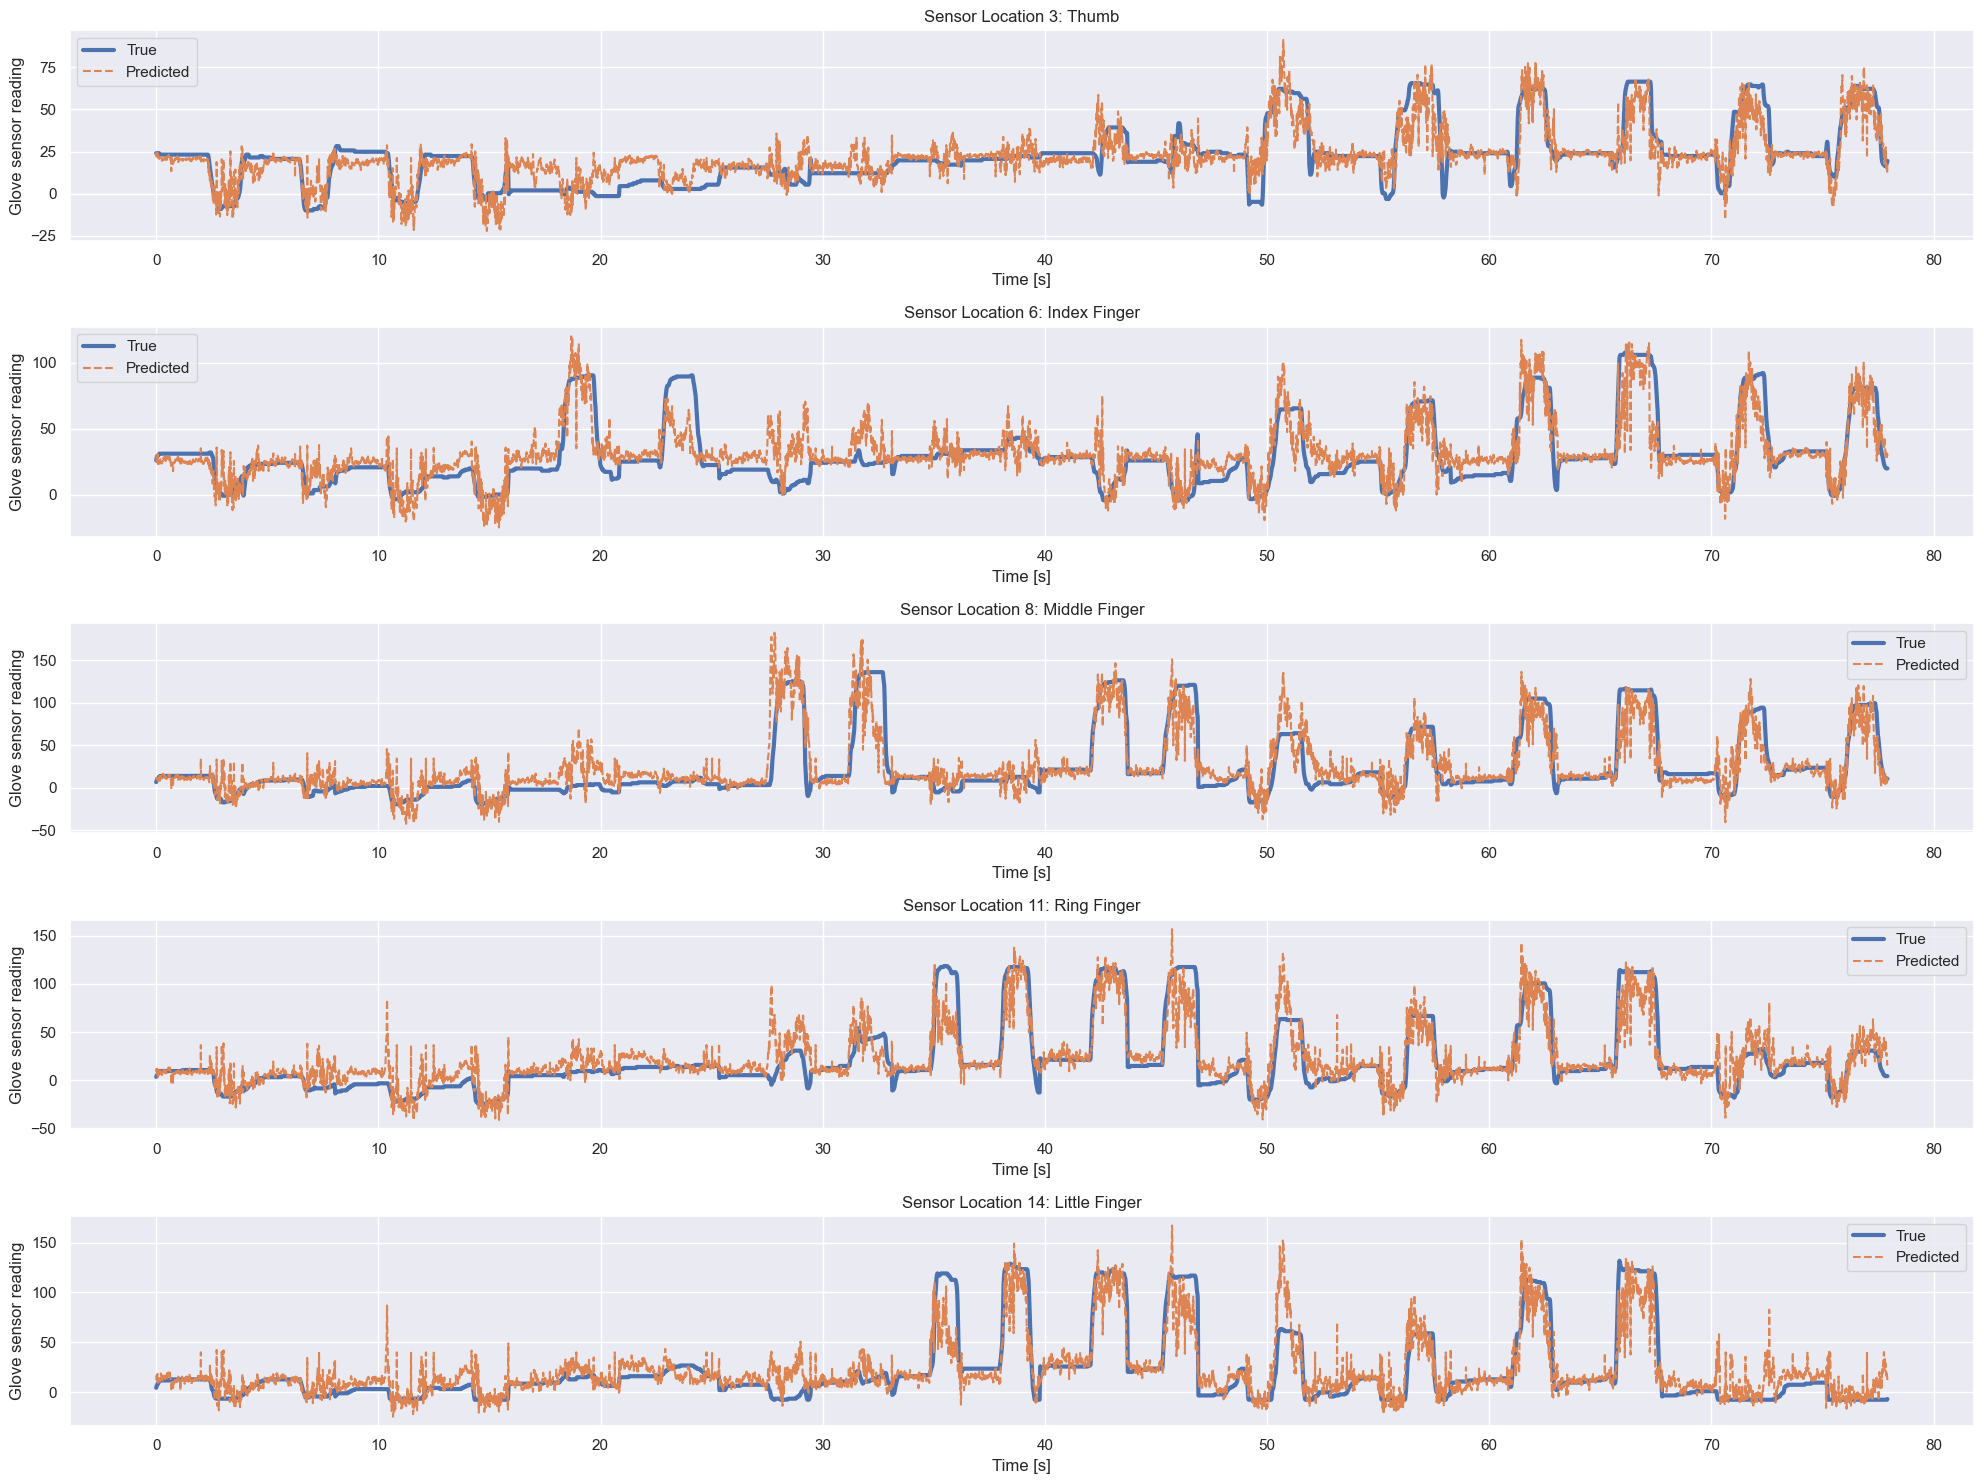

In [57]:
# Visualise Predictions on VAL SET

# Plot the true and predicted values for all finger angles - VAL set
time_axis = np.arange(Labels_val_mean.shape[0]) / 100 # fs = 100Hz, since the glove sensor data was sampled at 100 Hz
fig, ax = plt.subplots(5, 1, figsize=(20, 15))
for i in range(5):
    ax[i].plot(time_axis, Labels_val_mean[:,i], linewidth=3, label="True")
    ax[i].plot(time_axis, y_val_pred[:,i], linestyle="--", label="Predicted")
    ax[i].set_xlabel("Time [s]")  # set x-axis label
    ax[i].set_ylabel("Glove sensor reading")  # set y-axis label
    ax[i].legend()
    ax[i].set_title(title_names[i]) 

fig.tight_layout()
plt.show()

# Visualise predictions and explain

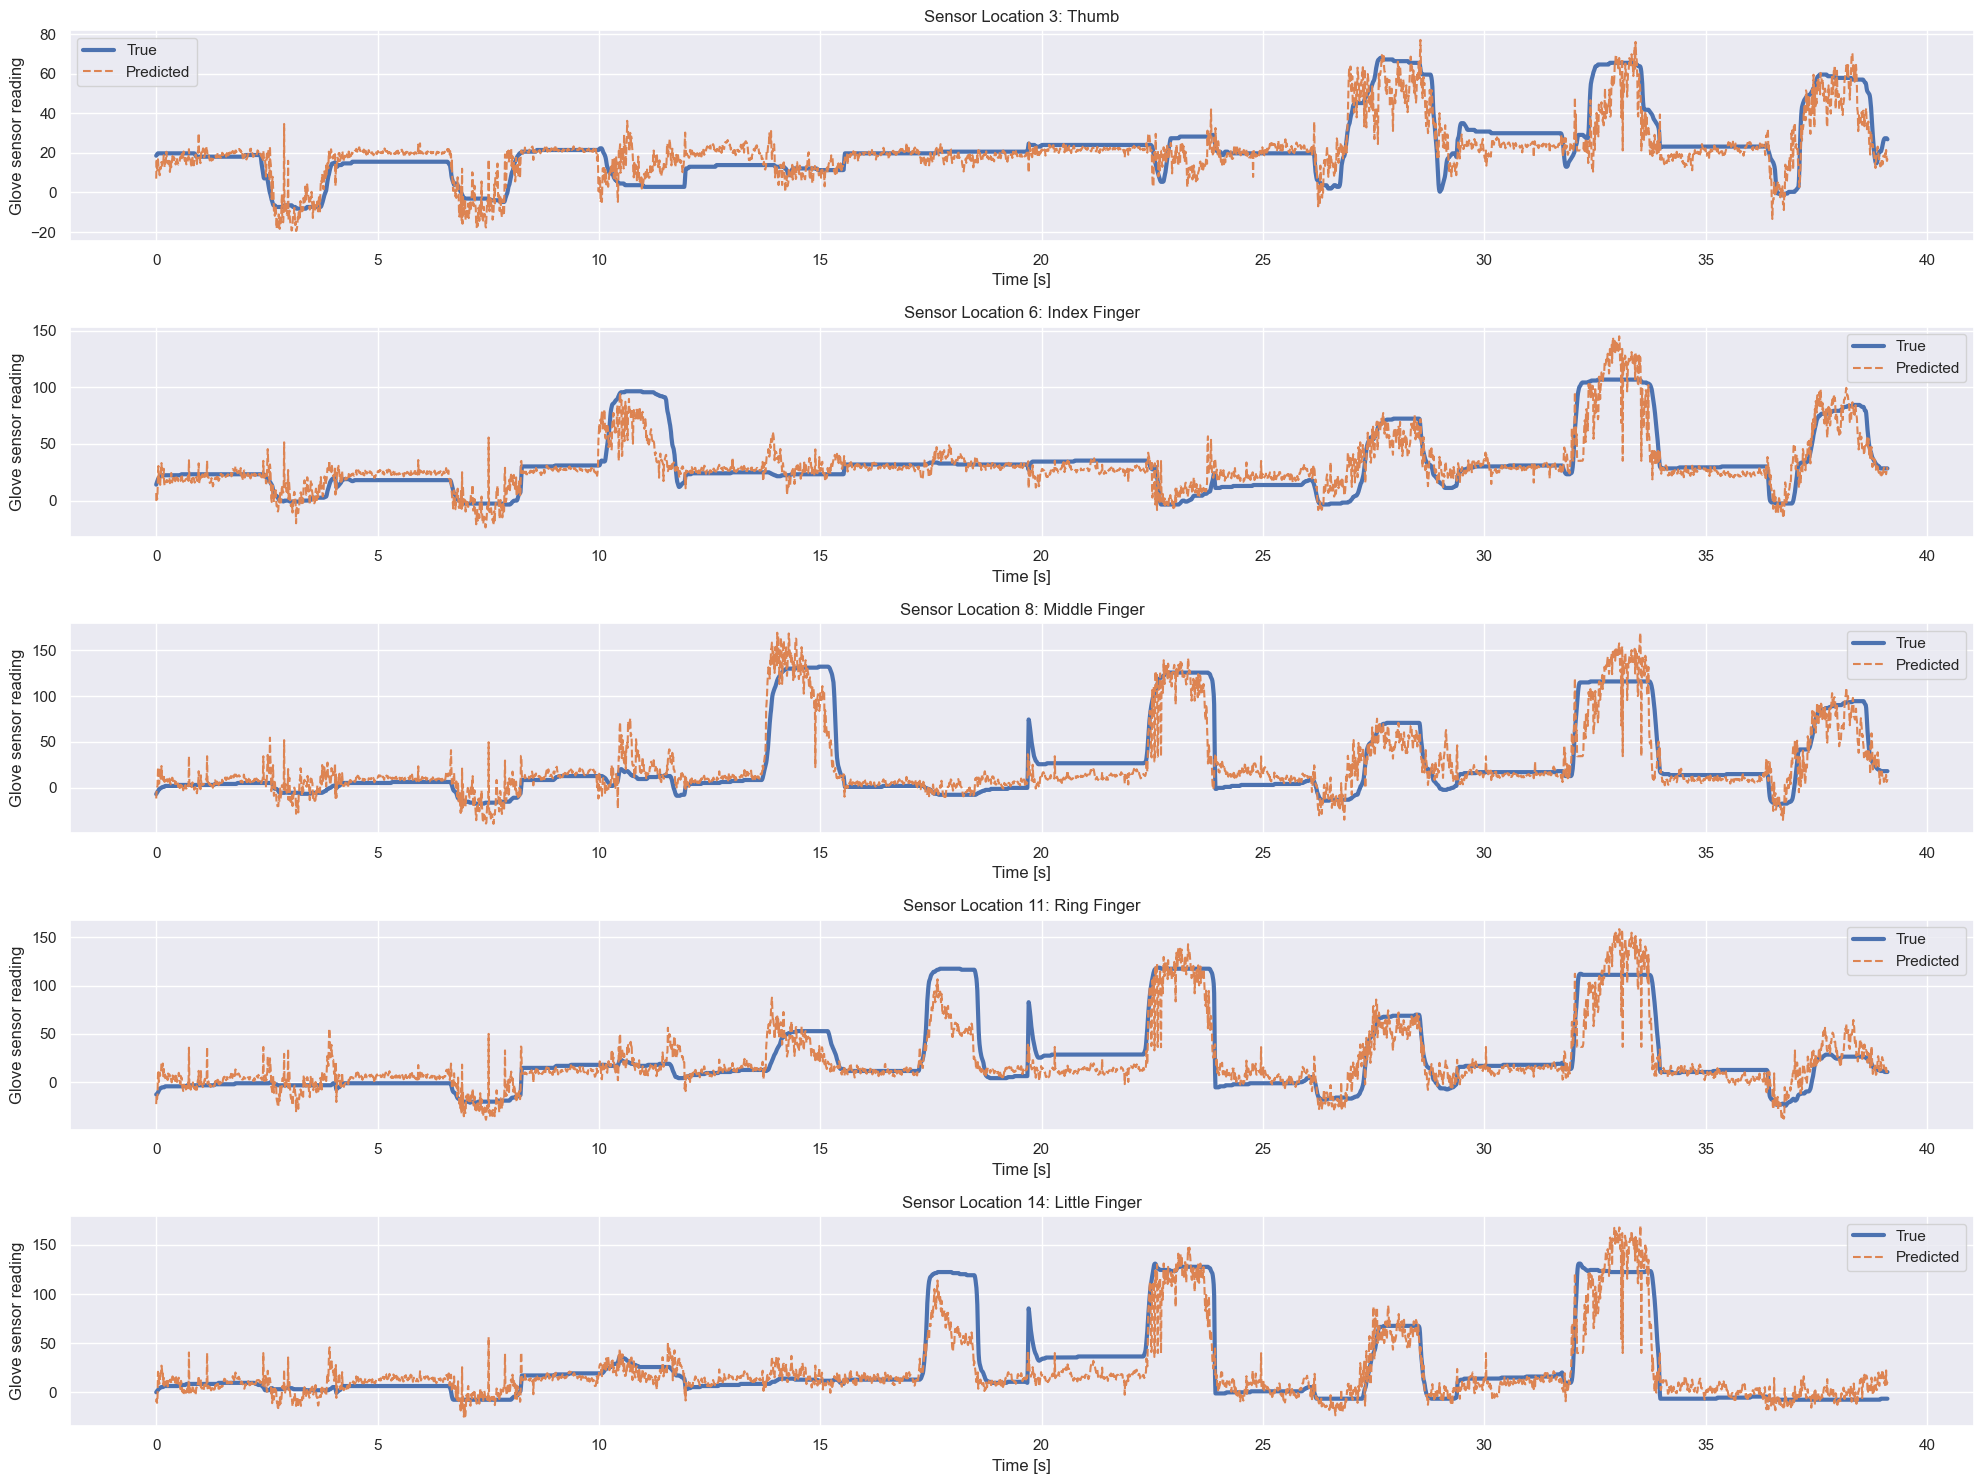

In [55]:
# Visualise Predictions on TEST SET

# Plot the true and predicted values for all finger angles - VAL set
time_axis = np.arange(Labels_test_mean.shape[0]) / 100 # fs = 100Hz, since the glove sensor data was sampled at 100 Hz
fig, ax = plt.subplots(5, 1, figsize=(20, 15))
title_names = ["Sensor Location 3: Thumb", "Sensor Location 6: Index Finger", "Sensor Location 8: Middle Finger", "Sensor Location 11: Ring Finger", "Sensor Location 14: Little Finger"]
for i in range(5):
    ax[i].plot(time_axis, Labels_test_mean[:,i], linewidth=3, label="True")
    ax[i].plot(time_axis, y_test_pred[:,i], linestyle="--", label="Predicted")
    ax[i].set_xlabel("Time [s]")  # set x-axis label
    ax[i].set_ylabel("Glove sensor reading")  # set y-axis label
    ax[i].legend()
    ax[i].set_title(title_names[i]) 
    
    #ax[i].set_xlim(0, 5000)


fig.tight_layout()
fig.savefig("predictions_test.png", dpi=300) 
plt.show()

In [59]:
for i in range(5):
    print("R2 - ", title_names[i], end=": ") 
    var_y = np.var(Labels_test_mean)
    r2 = 1 - mean_squared_error(Labels_test_mean[:,i], y_test_pred[:,i]) / var_y
    print(r2)

MSE -  Sensor Location 3: Thumb: 75.52459648536899
MSE -  Sensor Location 6: Index Finger: 192.5993150652555
MSE -  Sensor Location 8: Middle Finger: 363.6368713449136
MSE -  Sensor Location 11: Ring Finger: 333.5912777777238
MSE -  Sensor Location 14: Little Finger: 328.4907572349073


In [60]:
for i in range(5):
    print("R2 - ", title_names[i], end=": ") 
    var_y = np.var(Labels_test_mean)
    r2 = 1 - mean_squared_error(Labels_test_mean[:,i], y_test_pred[:,i]) / var_y
    print(r2)

R2 -  Sensor Location 3: Thumb: 0.9320131730478074
R2 -  Sensor Location 6: Index Finger: 0.8266231543919732
R2 -  Sensor Location 8: Middle Finger: 0.6726560856190378
R2 -  Sensor Location 11: Ring Finger: 0.6997029639287307
R2 -  Sensor Location 14: Little Finger: 0.704294424507772


The thumb and index finger joint angles have the best prediction performance, while the middle finger has the least MSE, so worst performance. The ring finger and little finger performance is lower than the thumb and index finger. We can see that our predictions are not always accurate at the peaks, and have a faster roll-off than the actual values. The error in the predictions of the ring and little finger is close to each other, possibly owing to the mechanical coupling effect seen in the ring and little finger. 

Overall, the different finger joints have different prediction performance. This could happen due to a couple of reasons:
* Our test set consists of one subject only. The difference could be attributed to the subtle differences in the subject’s anatomical ability with respect to their finger joint movements. 
* The sEMG channels could have picked up cross-talk due to overlapping muscle activations, and this could result in varying performance of EMG data in predicting different joint movements (for example, signals from certain muscles pronounced and some muscles being suppressed could show a difference in performance since the finger joints are activated by different muscles).
* The thumb and index finger are easier to decode because they have more independent muscles, so their EMG signals are clearer and easier for the model to separate. The middle finger is harder because its muscles are more closely linked with the index and ring fingers, which causes overlapping EMG activity and makes the signals less specific to the associated task. 
* This pattern is also reported in the literature, including in Effect of User Practice on Prosthetic Finger Control With an Intuitive Myoelectric Decoder, where middle-finger movements were harder to isolate due to shared muscles and unintentional co-activation.
